In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

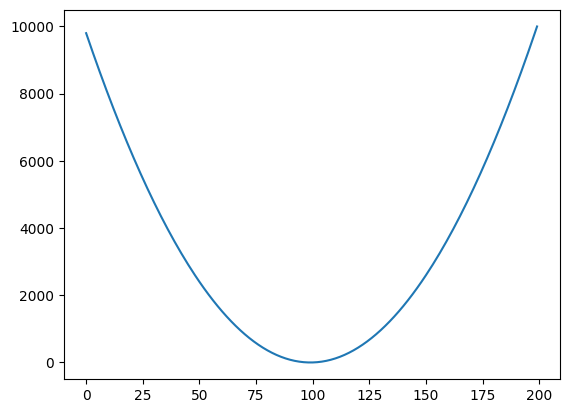

In [2]:
cos_wave = np.array([x ** 2 + 2 * x + 1 for x in np.arange(-100, 100, 1)])
plt.plot(cos_wave);

In [3]:
X = []
Y = []
sequence_length = 50
number_of_records = len(cos_wave) - sequence_length

In [4]:
for i in range(number_of_records - 50):
    X.append(cos_wave[i : i + sequence_length])
    Y.append(cos_wave[i + sequence_length])

In [5]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((100, 50), (100,))

In [6]:
X = (X - X.min()) / (X.max() - X.min())
Y = (Y - Y.min()) / (Y.max() - Y.min())

In [7]:
def sigmoid(x):
    g = 1 / (1 + np.exp(-x))
    return g

def tanh(x):
    g = np.tanh(x)
    return g

def sigmoid_derivative(z):
    a = sigmoid(z)
    g_prime = 1 - a**2
    return g_prime

def tanh_derivative(z):
    a = np.tanh(z)
    g_prime = 1 - a**2
    return g_prime
    
def lstm_init_param(x, number_of_nodes):
    # Create new dictionary
    parameters = {}

    # Get batch and sequence sizes from input vector x
    sequence_size = x.shape[0]
    batch_size = x.shape[1]
    
    # High and low limits for random number
    high = 0.50
    low = -0.50

    # Forget gate parameters
    parameters['Wfa'] = np.random.uniform(low, high, (number_of_nodes, number_of_nodes))
    parameters['Wfx'] = np.random.uniform(low, high, (number_of_nodes, sequence_size))
    parameters['bf']  = np.zeros((number_of_nodes, batch_size))

    # Update gate parameters
    parameters['Wua'] = np.random.uniform(low, high, (number_of_nodes, number_of_nodes))
    parameters['Wux'] = np.random.uniform(low, high, (number_of_nodes, sequence_size))
    parameters['bu']  = np.zeros((number_of_nodes, batch_size))

    # Output gate parameters
    parameters['Woa'] = np.random.uniform(low, high, (number_of_nodes, number_of_nodes))
    parameters['Wox'] = np.random.uniform(low, high, (number_of_nodes, sequence_size))
    parameters['bo']  = np.zeros((number_of_nodes, batch_size))

    # Cell state parameters
    parameters['Wca'] = np.random.uniform(low, high, (number_of_nodes, number_of_nodes))
    parameters['Wcx'] = np.random.uniform(low, high, (number_of_nodes, sequence_size))
    parameters['bc']  = np.zeros((number_of_nodes, batch_size))

    # Prediction layer
    parameters['Wya'] = np.random.uniform(low, high, (1, number_of_nodes))
    parameters['by']  = np.zeros((1, batch_size))

    # Initialize a[0] and c[0]
    parameters['c_prev'] = np.zeros((number_of_nodes, batch_size))
    parameters['a_prev'] = np.zeros((number_of_nodes, batch_size))

    return parameters
    
def lstm_forward_pass(x, a_prev, c_prev, parameters):

    # Initialize cache and yhat lists
    caches = []

    # Get T_steps from x
    T_steps = x.shape[1]

    # Get weights
    Wfa = parameters['Wfa']
    Wfx = parameters['Wfx']
    Wua = parameters['Wua']
    Wux = parameters['Wux']
    Woa = parameters['Woa']
    Wox = parameters['Wox']
    Wca = parameters['Wca']
    Wcx = parameters['Wcx']
    Wya = parameters['Wya']

    for t in range(T_steps):
        # z's for forget, update and output gates
        zf = np.dot(Wfa, a_prev) + np.dot(Wfx, x) 
        zu = np.dot(Wua, a_prev) + np.dot(Wux, x) 
        zo = np.dot(Woa, a_prev) + np.dot(Wox, x) 

        # Gates: Gf (forget), Gu (update) and Go (output)
        Gf = sigmoid(zf)
        Gu = sigmoid(zu)
        Go = sigmoid(zo)

        z_tilde = np.dot(Wca, a_prev) + np.dot(Wcx, x)
        c_tilde = np.tanh(z_tilde)                  # Candidate memory state
        c = Gf * c_prev + Gu * c_tilde              # Cell state
        a = Go * np.tanh(c)                         # Hidden state

        c_prev = c
        a_prev = a

        cache = (zf, zu, zo, Gf, Gu, Go, c_tilde, c, c_prev, a, a_prev, z_tilde)
        caches.append(cache)
    
    yhat = np.dot(Wya, a) 

    return yhat, caches
    
def compute_y_cost(yhat, y):
    
    m = y.shape[0]

    # Subsitute 1e-8 for 0 in yhat to prevent the calculation of log(0)
    # Also clip yhat to be 1 - 1e-8 to prevent the calculation of log(negative) and log(0)
    yhat[yhat == 0] = 1e-8
    yhat[yhat >= 1] = 1 - 1e-8

    # Compute loss              
    cost = (1. / m) * np.sum((y - yhat)**2) 
    
    return cost

In [8]:
X.shape

(100, 50)

In [9]:
number_of_nodes = 75
parameters = lstm_init_param(X.T, number_of_nodes)
yhat, caches = lstm_forward_pass(X.T, parameters["a_prev"], parameters["c_prev"], parameters)

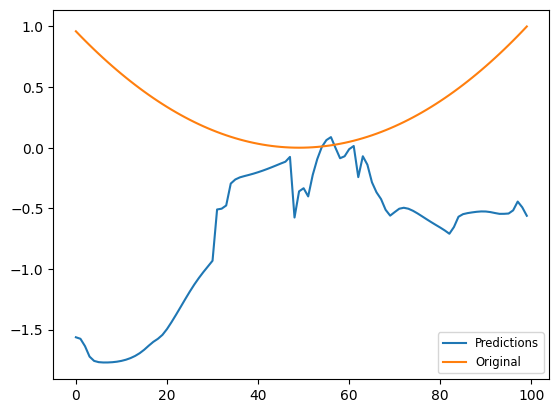

In [10]:
predictions = plt.plot((np.array(yhat).reshape((1, 100)).T), label = "Predictions")
original = plt.plot(Y.reshape(100), label = "Original")
legend = plt.legend(loc=4, fontsize='small', fancybox=True)

In [11]:
def lstm_backward_pass(x, y, yhat, number_of_nodes, caches, parameters):
    # Initialize gradients
    gradients = {}

    # Initialize T_steps and batch_size
    T_steps = x.shape[0]
    batch_size = x.shape[1]

    # Get weights from parameters
    Wfa = parameters['Wfa']
    Wfx = parameters['Wfx']
    bf  = parameters['bf']
    Wua = parameters['Wua']
    Wux = parameters['Wux']
    bu  = parameters['bu']
    Woa = parameters['Woa']
    Wox = parameters['Wox']
    bo  = parameters['bo']
    Wca = parameters['Wca']
    Wcx = parameters['Wcx']
    bc  = parameters['bc']
    Wya = parameters['Wya']
    by  = parameters['by']

    # Initialize da_next and dc_next
    da_next = np.zeros((number_of_nodes, batch_size))
    dc_next = np.zeros((number_of_nodes, batch_size))

    dz_prime = (-2 / y.shape[0]) * (y - yhat).T

    for t in range(T_steps - 1, -1, -1):
        zf, zu, zo, Gf, Gu, Go, c_tilde, c, c_prev, a, a_prev, z_tilde = caches[t]
        
        # Hidden to output gradients
        da = np.dot(Wya.T, dz_prime.T) + da_next
        dWya = np.dot(dz_prime.T, a.T)
        dby = dz_prime.T

        # Output gate gradients
        dzo = da * tanh_derivative(zo) * tanh(c)
        dc = da * Go * tanh_derivative(c) + dc_next

        # Update gate gradients
        dzu = dc * sigmoid_derivative(zu) * c_tilde

        # Forget gate gradients
        dzf = dc * sigmoid_derivative(zf) * c_prev 

        # Gradient for c_tilde
        dz_tilde = dc * Gu * tanh_derivative(z_tilde)

        # Parameters gradients
        ## Output gate
        dWoa = np.dot(dzo, a_prev.T)
        dWox = np.dot(dzo, x.T)
        dbo  = dzo
        da_prev_o  = np.dot(dzo.T, Woa)

        ## Update gate
        dWua = np.dot(dzu, a_prev.T)
        dWux = np.dot(dzu, x.T)
        dbu  = dzu
        da_prev_u  = np.dot(dzu.T, Wua)

        ## Forget gate
        dWfa = np.dot(dzf, a_prev.T)
        dWfx = np.dot(dzf, x.T)
        dbf  = dzf
        da_prev_f  = np.dot(dzf.T, Wfa)

        ## State
        dWca = np.dot(dz_tilde, a_prev.T)
        dWcx = np.dot(dz_tilde, x.T)
        dbc  = dz_tilde
        da_prev_c  = np.dot(dz_tilde.T, Wca)

        # Accumulation of all derivatives of x
        da_next = da_prev_o + da_prev_u + da_prev_f + da_prev_c
        dc_next = Gf * dc

        gradients = {
            'dWoa': dWoa,
            'dWox': dWox,
            'dbo' : dbo,
            'dWua': dWua,
            'dWux': dWux,
            'dbu' : dbu,
            'dWfa': dWfa,
            'dWfx': dWfx,
            'dbf' : dbf,
            'dWya': dWya,
            'dby' : dby
        }

        return gradients
        
def lstm_update_parameters(parameters, gradients, learning_rate):

    # Forget gate parameters update
    parameters['Wfa'] =  parameters['Wfa'] - learning_rate * gradients['dWfa']
    parameters['Wfx'] =  parameters['Wfx'] - learning_rate * gradients['dWfx']
    parameters['bf'] =  parameters['bf'] - learning_rate * gradients['dbf']

    # Update gate parameters update
    parameters['Wua'] =  parameters['Wua'] - learning_rate * gradients['dWua']
    parameters['Wux'] =  parameters['Wux'] - learning_rate * gradients['dWux']
    parameters['bu'] =  parameters['bu'] - learning_rate * gradients['dbu']

    # Output gate parameters update
    parameters['Woa'] =  parameters['Woa'] - learning_rate * gradients['dWoa']
    parameters['Wox'] =  parameters['Wox'] - learning_rate * gradients['dWox']
    parameters['bo'] =  parameters['bo'] - learning_rate * gradients['dbo']

    # Prediction parameters update
    parameters['Wya'] =  parameters['Wya'] - learning_rate * gradients['dWya']
    parameters['by'] =  parameters['by'] - learning_rate * gradients['dby']

    return parameters

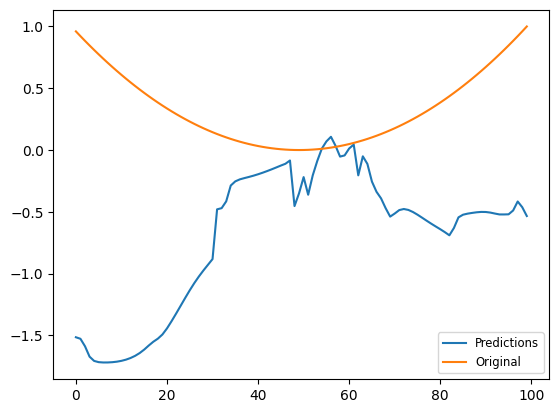

In [12]:
gradients = lstm_backward_pass(X.T, Y, yhat, number_of_nodes, caches, parameters)
parameters_1 = lstm_update_parameters(parameters, gradients, 0.0020)
yhat_1, caches_1 = lstm_forward_pass(X.T, parameters["a_prev"], parameters["c_prev"], parameters_1)

predictions = plt.plot((np.array(yhat_1).reshape((1, 100)).T), label = "Predictions")
original = plt.plot((Y.T), label = "Original")
legend = plt.legend(loc=4, fontsize='small', fancybox=True)

In [13]:
def lstm_model(x, y, number_of_nodes, iterations, learning_rate):

    costs = []
    prediction = []
    T_steps = x.shape[0]
    parameters = lstm_init_param(x, number_of_nodes)

    for i in range(0, iterations + 1):

        a_prev = parameters['a_prev']
        c_prev = parameters['c_prev']
        
        preds, caches = lstm_forward_pass(x, a_prev, c_prev, parameters)
        
        preds = np.array(preds).T.reshape((1, 100))
        
        cost = compute_y_cost(preds, y)

        gradients = lstm_backward_pass(x, y, preds, number_of_nodes, caches, parameters)

        parameters = lstm_update_parameters(parameters, gradients, learning_rate)

        costs.append(cost)

        print("Cost after epoch ", i, ": ", cost)

    return preds, costs, parameters

Cost after epoch  0 :  0.25335222031687116
Cost after epoch  1 :  0.22904586979981603
Cost after epoch  2 :  0.2092507517132447
Cost after epoch  3 :  0.19343809474310075
Cost after epoch  4 :  0.18378017798034843
Cost after epoch  5 :  0.17314317304627647
Cost after epoch  6 :  0.1616812870505639
Cost after epoch  7 :  0.15281307234948013
Cost after epoch  8 :  0.14522238592251424
Cost after epoch  9 :  0.14141745372392675
Cost after epoch  10 :  0.13633648655910915
Cost after epoch  11 :  0.12949633751285267
Cost after epoch  12 :  0.1269746409722336
Cost after epoch  13 :  0.1213527130758939
Cost after epoch  14 :  0.11655601315389383
Cost after epoch  15 :  0.11391816564714491
Cost after epoch  16 :  0.11666139056215742
Cost after epoch  17 :  0.11361129666272282
Cost after epoch  18 :  0.11656534643767032
Cost after epoch  19 :  0.1112971871598223
Cost after epoch  20 :  0.10789462707993318
Cost after epoch  21 :  0.10483704419734968
Cost after epoch  22 :  0.10203791289001167
Cos

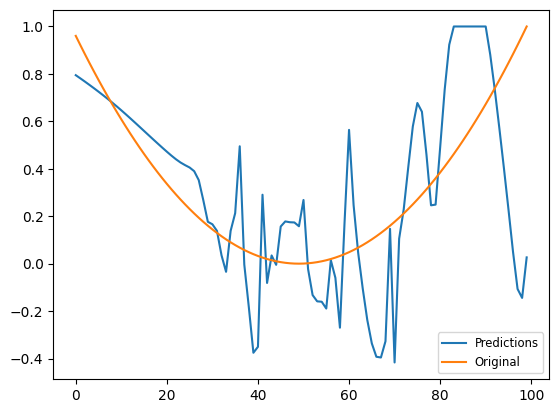

In [14]:
preds, costs, parameters = lstm_model(X.T, Y, number_of_nodes,\
                                      iterations = 200,\
                                      learning_rate = 0.01)

predictions = plt.plot((np.array(preds).reshape((1, 100)).T), label = "Predictions")
original = plt.plot((Y.T), label = "Original")
legend = plt.legend(loc=4, fontsize='small', fancybox=True)